# Adaboost ou XGBoost ?

Deux algorithmes de boosting connus sont Adaboost & XGBoost, voyons voir la performance de chacun de ces algorithmes sur le dataset d'AIRBNB Seattle. Notre but va être de prédire le prix d'un appartement en fonction des caractéristiques qu'on nous a donné. 

1. Importez les librairies usuelles 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

2. Importez le dataset ```listings.csv```

In [ ]:
listings = pd.read_csv("https://raw.githubusercontent.com/JedhaBootcamp/FULL_STACK_12_WEEK_PROGRAM/master/S0.4%20--%20R%C3%A9duction%20de%20Dimensions%20%26%20Boosting/S4-3%20--%20Boosting%20-%20Adaboost%20%26%20XGBoost/S4-3B/Dataset/listings.csv?token=AFB53D5MGH4TUS3R5JTWTPC6HPUAI")
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

3. On a beaucoup de données dans ce dataset. Affichez toutes les colonnes du dataset

In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

4. Révisons un peu Seaborn, affichez la distribution des prix dans le dataset 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


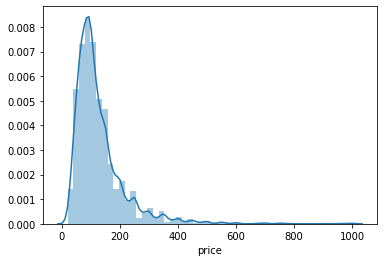

In [ ]:
listings.price2 = listings.price.apply(lambda x: x[1:])
listings.price2 = listings.price2.str.replace(",","").astype(float)
sns.distplot(listings.price2)

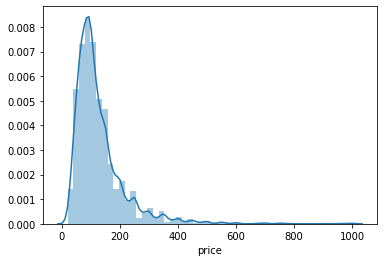

In [ ]:
listings.price = listings.price.apply(lambda x: x[1:])
listings.price = listings.price.replace("1,000.00", "1000").astype(float)
sns.distplot(listings.price)

5. Supprimez les outliers pour ne garder que les appartements qui ont un prix inférieur à 400$/nuit 

In [ ]:
avg_priced_dataset = listings[listings.price <= 400]
avg_priced_dataset.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.755000e+03,3.755000e+03,3.755000e+03,3753.000000,3753.000000,3755.000000,3755.000000,3755.000000,3739.000000,3749.000000,3754.000000,96.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3119.000000,3108.000000,3113.000000,3108.000000,3115.000000,3111.000000,3110.000000,0.0,3755.000000,3138.000000
mean,5.556910e+06,2.016010e+13,1.579411e+07,7.146283,7.146283,47.628887,-122.332935,3.272703,1.236026,1.270739,1.690730,836.437500,120.749933,1.639414,2.365113,780.472703,16.821305,36.885220,58.189880,244.672703,22.443675,94.517153,9.635135,9.552843,9.784106,9.807705,9.607522,9.452412,NaN,2.944607,2.096539
std,2.966011e+06,0.000000e+00,1.459490e+07,28.711382,28.711382,0.043270,0.031759,1.868531,0.556459,0.824873,1.056105,650.483429,68.744681,1.236517,16.441420,1696.449365,12.161880,23.306987,34.007566,126.911684,37.980257,6.597540,0.700417,0.801180,0.599360,0.571147,0.629853,0.749495,NaN,5.882812,1.827941
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.256584e+06,2.016010e+13,3.258368e+06,1.000000,1.000000,47.609078,-122.354154,2.000000,1.000000,1.000000,1.000000,415.000000,75.000000,1.000000,1.000000,60.000000,2.000000,13.500000,29.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.700000
50%,6.127974e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623451,-122.328750,2.000000,1.000000,1.000000,1.000000,750.000000,100.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.560000
75%,8.047928e+06,2.016010e+13,2.592334e+07,3.000000,3.000000,47.662976,-122.310698,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.020000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,10.000000,3000.000000,400.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


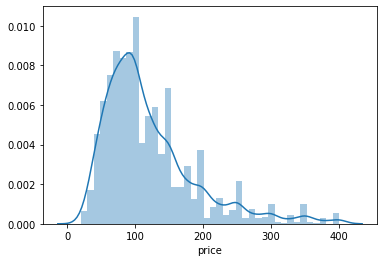

In [ ]:
sns.distplot(avg_priced_dataset.price)

6. Exprimez le prix en fonction des variables suivantes : 

- ```room type```
- ```beds```
- ```property type```

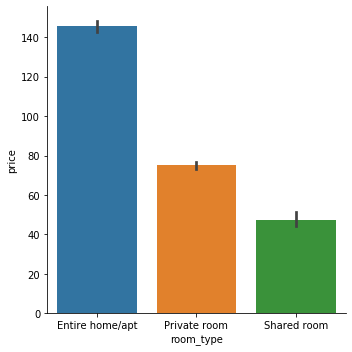

In [ ]:
sns.catplot(x="room_type", y="price", data=avg_priced_dataset, kind="bar")

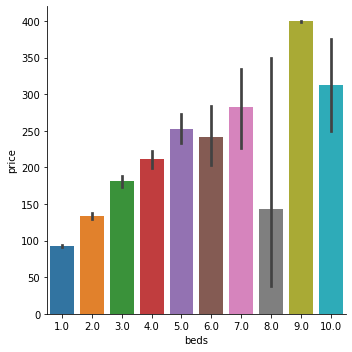

In [ ]:
sns.catplot(x="beds", y="price", data=avg_priced_dataset, kind="bar")

In [ ]:
avg_priced_dataset[avg_priced_dataset.beds==8]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
997,8424532,https://www.airbnb.com/rooms/8424532,20160104002432,2016-01-04,Ideal Home for Small Reunions,Lge home- corner lot -walking distance to Lak...,NaN,Lge home- corner lot -walking distance to Lak...,none,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/107150138/...,https://a0.muscache.com/im/pictures/107150138/...,https://a0.muscache.com/ac/pictures/107150138/...,https://a0.muscache.com/ac/pictures/107150138/...,658155,https://www.airbnb.com/users/show/658155,Joe,2011-06-02,"Seattle, Washington, United States",Addicted renovator of homes. Love helping peo...,within an hour,100%,100%,t,https://a2.muscache.com/ac/users/658155/profil...,https://a2.muscache.com/ac/users/658155/profil...,Capitol Hill,13.0,13.0,"['email', 'phone', 'reviews', 'kba']",t,t,"32nd Avenue, Seattle, WA 98122, United States",Leschi,Leschi,Central Area,Seattle,WA,...,5.0,8.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,350.0,NaN,NaN,$500.00,$250.00,1,$0.00,7,1125,today,t,18,40,70,292,2016-01-04,2,2015-10-08,2015-10-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.67
1069,6119821,https://www.airbnb.com/rooms/6119821,20160104002432,2016-01-04,Green Tortoise Hostel,Our centrally located Seattle hostel is famous...,Conveniently located at First Avenue and Pike ...,Our centrally located Seattle hostel is famous...,none,The Green Tortoise is located right in the hea...,Towel rentals: $1 Lock rentals: $5 ($3 refunde...,We're located just a few blocks from the LINK ...,https://a1.muscache.com/ac/pictures/76269495/3...,https://a1.muscache.com/im/pictures/76269495/3...,https://a1.muscache.com/ac/pictures/76269495/3...,https://a1.muscache.com/ac/pictures/76269495/3...,31751507,https://www.airbnb.com/users/show/31751507,Rex,2015-04-22,"Seattle, Washington, United States",NaN,within an hour,100%,100%,f,https://a0.muscache.com/ac/users/31751507/prof...,https://a0.muscache.com/ac/users/31751507/prof...,Pike Place Market,2.0,2.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"Pike Street, Seattle, WA 98101, United States",Pike Place Market,Pike-Market,Downtown,Seattle,WA,...,1.0,8.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,Breakfas...",NaN,38.0,NaN,NaN,NaN,$6.00,1,$44.00,1,1125,3 months ago,t,20,50,75,342,2016-01-04,19,2015-05-19,2016-01-01,93.0,9.0,9.0,9.0,9.0,10.0,9.0,f,NaN,WASHINGTON,f,moderate,f,f,2,2.47
1073,8212989,https://www.airbnb.com/rooms/8212989,20160104002432,2016-01-04,Green Tortoise,Our centrally located Seattle hostel is famous...,NaN,Our centrally located Seattle hostel is famous...,none,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/106990054/...,https://a0.muscache.com/im/pictures/106990054/...,https://a0.muscache.com/ac/pictures/106990054/...,https://a0.musc

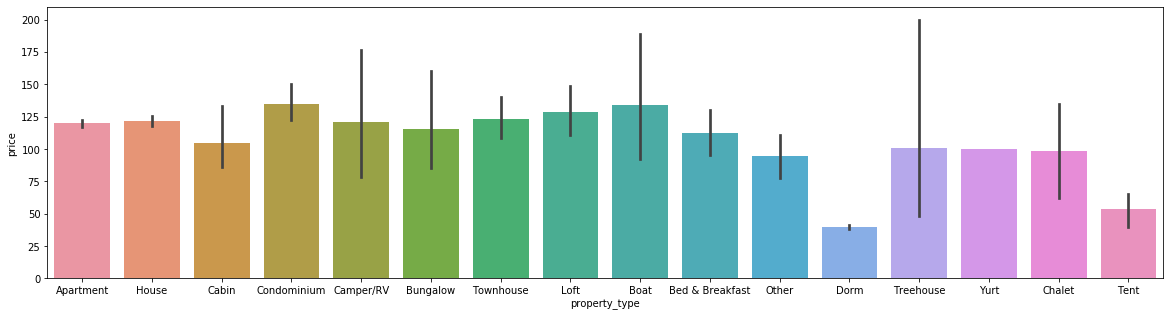

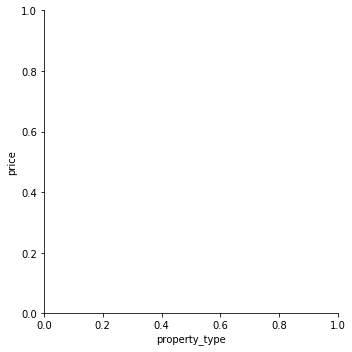

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.catplot(x="property_type", y="price", data=avg_priced_dataset, kind="bar", ax=ax)

7. Séparez la variable cible de votre dataset

In [ ]:
X = avg_priced_dataset.loc[:, avg_priced_dataset.columns!="price"]
#X = avg_priced_dataset.drop(["price"], axis = 1)
y = avg_priced_dataset.loc[:, avg_priced_dataset.columns=="price"]

8. Il faut qu'on écrème quelques variables explicatives de notre jeu de données. Commencer par simplement enlever les variables qui expriment un ```id``` quelconque ou urls. On enlèvera également les variables qui contiennent des textes longs comme ```notes```

De la même manière, on enlèvera  toutes les variables qui décrivent le prix mensuel ou hebdomadaire comme  ```monthly price```

Votre dataset devrait contenir uniquement les variables catégoriques et numériques une fois votre nettoyage fait. 

A la fin, votre dataset contiendra les variables suivantes : 

```
Index(['experiences_offered', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')
```

In [ ]:
a=X.isnull().sum()/X.shape[0]*100
a.sort_values(ascending=False)

license             100.000000
square_feet          97.443409
monthly_price        60.053262
security_deposit     51.504660
weekly_price         47.270306
                       ...    
smart_location        0.000000
market                0.000000
state                 0.000000
city                  0.000000
id                    0.000000
Length: 91, dtype: float64

In [ ]:
X_clean = X.drop(["host_since", 
            "host_location", 
            "host_about", 
            "host_thumbnail_url", 
            "host_picture_url",
           "license",
           "monthly_price",
           "square_feet",
            "host_verifications", 
        "street", 
        "neighbourhood", 
        "neighbourhood_cleansed", 
        "city", 
        "state", 
        "market", 
        "smart_location",
        "country_code",
        "country",
        "is_location_exact",
        "amenities",
        "jurisdiction_names",
        "first_review",
        "last_review",
        "calendar_last_scraped",
        "weekly_price",
            "notes",
                  "neighborhood_overview",
         "name",
                  "description",
                  "listing_url" ,
"host_id",
"host_url",
                 "scrape_id",
                 "space",
                 "picture_url",
                 "last_scraped",
                 "host_name",
                 "medium_url",
                 "summary",
                 "xl_picture_url",
                 "transit",
                 "thumbnail_url",
                 "host_neighbourhood",
                 "zipcode",
                 "calendar_updated",
                 "license","id"], axis=1)

9 Reste-t-il des valeurs manquantes? Certaines peuvent elles être traîtées sans avoir recours à l'interpolation ? Les variables sont elles toutes dans un format adapté ? Si non appliquez des transformations adaptées.

In [ ]:
X_clean.isnull().sum().sort_values()

experiences_offered                    0
calculated_host_listings_count         0
minimum_nights                         0
maximum_nights                         0
has_availability                       0
availability_30                        0
availability_60                        0
guests_included                        0
availability_90                        0
number_of_reviews                      0
requires_license                       0
instant_bookable                       0
cancellation_policy                    0
require_guest_profile_picture          0
require_guest_phone_verification       0
availability_365                       0
bed_type                               0
extra_people                           0
accommodates                           0
room_type                              0
longitude                              0
latitude                               0
neighbourhood_group_cleansed           0
property_type                          1
beds            

In [ ]:
# Pour la suite, nous remplirons les valeurs NaN de la manière la plus simple possible 
X_clean.cleaning_fee = X_clean.cleaning_fee.apply(lambda x: float(x[1:])/100 if type(x) == str else x)
X_clean.cleaning_fee = X_clean.cleaning_fee.fillna(0)

In [ ]:
# Nous devons enlever le caractère $ de chacun des prix pour rendre les variables numériques
X_clean["host_response_rate_clean"] = X_clean.host_response_rate.apply(lambda x: float(x[:-1])/100 if type(x) == str else x)
X_clean = X_clean.drop("host_response_rate", axis =1)


In [ ]:
X_clean["host_acceptance_rate_clean"] = X_clean.host_acceptance_rate.apply(lambda x: int(x[:-1])/100 if type(x) == str else x)
X_clean = X_clean.drop("host_acceptance_rate", axis = 1)

In [ ]:
X_clean.host_has_profile_pic = X_clean.host_has_profile_pic.fillna("f")
X_clean.host_identity_verified = X_clean.host_identity_verified.fillna("f")

X_clean.host_response_time = X_clean.host_response_time.fillna("Unknown")
X_clean.host_is_superhost = X_clean.host_is_superhost.fillna("Unknown")
X_clean.property_type = X_clean.property_type.fillna("unknown")

X_clean.extra_people = X_clean.extra_people.apply(lambda x: float(x[1:]))
X_clean.security_deposit = X_clean.security_deposit.apply(lambda x: float(str(x).replace(",","").replace("nan","$0")[1:]))
X_clean.security_deposit = X_clean.security_deposit.fillna(0)


10. Vérifiez que toutes les variables numériques le sont effectivement bien. (N'oubliez pas de regarder y)

In [ ]:
y = y.apply(lambda x: float(x[1:]) if type(x)==str else x)

11. Séparez les variables en deux groupes, les variables numériques d'un côté et les qualitatives de l'autre.

In [ ]:
num_col = X_clean.select_dtypes([np.number]).columns
cat_col = X_clean.select_dtypes("object").columns

X_num = X_clean[num_col]
X_cat =  pd.get_dummies(X_clean[cat_col],drop_first=True)

12. Faites maintenant un ```train_test_split```

In [ ]:
from sklearn.model_selection import train_test_split



X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_num, X_cat, y, test_size =0.2)

In [ ]:
X_train_cat.shape

(3004, 51)

13. Normalisez ```X_train_num``` & ```X_test_num``` et rassemblez les deux groupes de variables

In [ ]:
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler()


X_train_num_norm = pd.DataFrame(sc_x.fit_transform(X_train_num),columns=X_train_num.columns, index = X_train_num.index)
X_test_num_norm = pd.DataFrame(sc_x.transform(X_test_num),columns=X_test_num.columns, index = X_test_num.index)

X_train = pd.merge(X_train_num_norm, X_train_cat,left_index=True, right_index=True)
X_test = pd.merge(X_test_num_norm, X_test_cat,left_index=True, right_index=True)



C:\Users\remi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\remi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


14. Gérez les valeurs NaN. Utilisez les stratégies que vous préférez 

In [ ]:
!pip install missingpy
from missingpy import KNNImputer
imputer = KNNImputer()

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


C:\Users\remi\Anaconda3\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


15. Entrainez d'abord un modèle d'Adaboost standard et regardez votre score 


In [ ]:

from sklearn.ensemble import AdaBoostRegressor 
regressor_ada = AdaBoostRegressor()
regressor_ada.fit(X_train, y_train)
regressor_ada.score(X_test, y_test)

#np.sqrt(np.mean((regressor_ada.predict(X_test) - y_test.values)**2))

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.397062940509919

In [ ]:
AdaBoostRegressor?

In [ ]:
np.mean(y_test)

price    117.98269
dtype: float64

16. Entrainez ensuite un modèle XGBoost et regardez votre score 

In [ ]:
!pip install xgboost
from xgboost import XGBRegressor
regressor_xgb = XGBRegressor()
regressor_xgb.fit(X_train, y_train)
regressor_xgb.score(X_test, y_test)

[13:51:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6289208959529866

17. Par défaut, Adaboost prend des decision trees comme modèle a booster. Tentez de mettre une regression linéaire 

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
regressor_ada = AdaBoostRegressor(lin_reg)
regressor_ada.fit(X_train, y_train)
regressor_ada.score(X_test, y_test)

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.49554711825857933

In [ ]:
regressor_ada.score(X_train, y_train)


0.5897919146850429

18. La régression linéaire n'était pas la meilleure idée mais peut être qu'on peut faire une grid_search sur le ```learning rate``` & ```n_estimators```pour rattraper le score de XGBoost ?

In [ ]:
from sklearn.model_selection import GridSearchCV
regressor_ada = AdaBoostRegressor()
parameters = {'n_estimators':[40,50,70, 100, 150, 200],
              "learning_rate":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5]}

regressor_ada_best = GridSearchCV(regressor_ada, parameters)
regressor_ada_best.fit(X_train, y_train)

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 50, 70, 100, 150, 200], 'learning_rate': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
regressor_ada_best.best_params_

{'learning_rate': 0.5, 'n_estimators': 40}

In [ ]:
regressor_ada_best.best_estimator_.score(X_test,y_test)

0.4124648389834829

In [ ]:
from sklearn.model_selection import GridSearchCV
regressor_ada = AdaBoostRegressor(n_estimators=40,learning_rate=0.5)
regressor_ada.fit(X_train, y_train)

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='linear',
         n_estimators=40, random_state=None)

In [ ]:
regressor_ada.score(X_test,y_test)

0.4357496728051814

---> Même avec beaucoup plus d'estimateurs, nous n'arrivons pas au score de XGBoost

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, y_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [ ]:
tree_regressor.score(X_test, y_test)

0.24679212855978216

In [ ]:
from sklearn.ensemble import BaggingRegressor
bagging_regressor = BaggingRegressor(n_estimators=40)
bagging_regressor.fit(X_train, y_train)

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:397: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=40, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [ ]:
bagging_regressor.score(X_test,y_test)

0.5942781300103948

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.5,n_estimators=40)
gbr.fit(X_train, y_train)

C:\Users\remi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
gbr.score(X_test,y_test)

0.6146633344203437

In [ ]:
from sklearn.externals import joblib
joblib.dump(gbr, 'test.joblib') 

['test.joblib']

In [ ]:
loaded_model = joblib.load('test.joblib')
result = loaded_model.score(X_test,y_test)
print(result)

0.6146633344203437
